In [ ]:
!pip install transformers
!pip install accelerate
# TODO: check lr scheduler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 106.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 5.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import cohen_kappa_score as kappa
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import GPT2Tokenizer, GPT2Model
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import os
import time
import pathlib

# log folder to save log files
log_folder = '/content/drive/MyDrive/asap/'

# target column
target_column = "score"

# hyper parameters
hp = {
    "base_model": "gpt2",
    "lr": 1e-4,
    "num_epochs": 25,
    "batch_size": 2,
    "use_amp": True,
    "mixed_precision": "fp16",
}

# Prepare ASAP Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Original kaggle training set
kaggle_dataset  = pd.read_csv('/content/drive/MyDrive/GPT-2 MODEL/training_set_rel3.tsv', sep='\t', encoding = "ISO-8859-1")

# Smaller training set used for this project
dataset_df = pd.DataFrame(
  {
    'essay_id' : kaggle_dataset['essay_id'],
    'essay_set' : kaggle_dataset['essay_set'],
    'essay' : kaggle_dataset['essay'],
    'rater1' : kaggle_dataset['rater1_domain1'],
    'rater2' : kaggle_dataset['rater2_domain1'],
    'score' : kaggle_dataset['domain1_score']
  })
dataset_df.head()

,essay_id,essay_set,essay,rater1,rater2,score
0,1,1,"Dear local newspaper, I think effects computer...",4,4,8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,10
4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,8


## Use essay_set=2 for classification

In [ ]:
essay_df = dataset_df[dataset_df['essay_set'] == 2].copy()
essay_df.shape

# essay_df = dataset_df.loc[(dataset_df['essay_set'] == 3) | (dataset_df['essay_set'] == 4) | (dataset_df['essay_set'] == 5) | (dataset_df['essay_set'] == 6)].copy()
# essay_df.shape

(1800, 6)

In [ ]:
import numpy as np
# Use minimum score
rater_1 = essay_df["rater1"].to_numpy()
rater_2 = essay_df["rater2"].to_numpy()

min_score = np.minimum(rater_1, rater_2)
max_score = np.maximum(rater_1, rater_2)

essay_df['min_score'] = min_score
essay_df['max_score'] = max_score

In [ ]:
essay_df['score'].value_counts()

4    778
3    763
2    153
5     75
1     24
6      7
Name: score, dtype: int64

In [ ]:
essay_df['score'] = essay_df['score'].astype(int)


In [ ]:
!pip install googletrans==4.0.0-rc1


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 10.2 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17396 sha256=37ed711ef18ce02aec4c2c13614dcecfb2da91bdb64ae9001b57dcce03d52a65
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling c

In [ ]:
from googletrans import Translator
import pandas as pd

def back_translate(text):
    translator = Translator()
    target_language = 'tr'  # set the target language directly as Turkish

    # Translate from English to the target language
    translated_text = translator.translate(text, dest=target_language).text

    # Back-translate from the target language to English
    back_translated_text = translator.translate(translated_text, dest='en').text

    return back_translated_text

def augment_data(df, column, value, fraction):
    subset = df[df[column] == value]
    augmented_subset = subset.sample(frac=fraction, replace=True)

    new_rows = []
    max_essay_id = df['essay_id'].max()

    for _, row in augmented_subset.iterrows():
        max_essay_id += 1
        new_rows.append({
            'essay_id': max_essay_id,
            'essay_set': row['essay_set'],
            'essay': back_translate(row['essay']),
            'rater1': row['rater1'],
            'rater2': row['rater2'],
            'score': value
        })

    return pd.DataFrame(new_rows)

# Apply data augmentation to classes in essay_df that have less than 50 samples
classes_to_augment = [1, 6]
augmented_dataframes = []

for value in classes_to_augment:
    augmented_dataframes.append(augment_data(essay_df, 'score', value, 1.0))

augmented_df = pd.concat(augmented_dataframes, ignore_index=True)

#Add the augmented data to the original data.
essay_df = pd.concat([essay_df, augmented_df], ignore_index=True)

print(f"Total data size after augmentation: {len(essay_df)}")


Total data size after augmentation: 1831


In [ ]:
essay_df['score'].value_counts()

4    778
3    763
2    153
5     75
1     48
6     14
Name: score, dtype: int64

In [ ]:
essay_df[target_column] - essay_df[target_column].min()

0       3
1       0
2       1
3       3
4       3
       ..
1826    5
1827    5
1828    5
1829    5
1830    5
Name: score, Length: 1831, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

essay_df['target_score'] = essay_df[target_column] - essay_df[target_column].min()

X, y = essay_df['essay'].to_list(), essay_df['target_score'].to_numpy()
num_labels = essay_df[target_column].unique().size

# 60 / 40 train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42) # stratify=y, this paramter will not work if any class has number of examples lower than 2

# split test to half to get 60 / 20 / 20 split

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.50, random_state=42) # stratify=y_test

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

# a torch dataset implementation for ASAP dataset
class EssayDataset(Dataset):
    def __init__(self, essays, targets, tokenizer):
        self.essays = essays
        self.targets = targets
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.essays)

    def __getitem__(self, idx):
        text = str(self.essays[idx])
        encoded_input = tokenizer(text, truncation=True, return_tensors='pt').to(device)

        return encoded_input['input_ids'].squeeze(), encoded_input['attention_mask'].squeeze(), self.targets[idx]

In [ ]:
# collater function to pad tokens
def collate_fn(batch):
    PAD_TOKEN_ID = 50256 # Use tokenizer.pad_token_id to check
    input_ids_list, attention_mask_list, targets = [], [], []

    for input_ids, attention_mask, target in batch:
        input_ids_list.append(input_ids)
        attention_mask_list.append(attention_mask)
        targets.append(target)

    # Pad the batch to the maximum sequence length within that batch using the tokenizer's pad token
    max_length = max(len(ids) for ids in input_ids_list)
    padded_input_ids = []
    padded_attention_mask = []

    for input_ids, attention_mask in zip(input_ids_list, attention_mask_list):
        pad_length = max_length - len(input_ids)
        padded_input_ids.append(torch.cat([input_ids, torch.tensor([PAD_TOKEN_ID] * pad_length, device=device, dtype=torch.long)]))
        # add zeros to attention mask for padds
        padded_attention_mask.append(torch.cat([attention_mask, torch.zeros(pad_length, dtype=torch.long, device=device)]))

    return torch.stack(padded_input_ids), torch.stack(padded_attention_mask), torch.tensor(targets)

In [ ]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained(hp['base_model'])
tokenizer.pad_token_id = tokenizer.eos_token_id

In [ ]:
from transformers import GPT2ForSequenceClassification

class ClassifierLayer(torch.nn.Module):

  def __init__(self, input_size, output_size, bias=False):
    super(ClassifierLayer, self).__init__()

    self.dropout = torch.nn.Dropout(0.5)
    self.linear = torch.nn.Linear(input_size, output_size, bias=bias)

  def forward(self, x):
    inputs = self.dropout(x)
    return self.linear(inputs)

class GPT2Classification(GPT2ForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.score = ClassifierLayer(config.n_embd, self.num_labels, bias=False)

        self.post_init()

In [ ]:
from accelerate import Accelerator

# use fp16 mixed precision to improve training speed
accelerator = Accelerator(mixed_precision=hp['mixed_precision']) # fp16
device = accelerator.device

model = GPT2Classification.from_pretrained(hp['base_model'], num_labels=num_labels)
#model = GPT2ForSequenceClassification.from_pretrained(hp['base_model'], num_labels=num_labels)
model.to(device)
tokenizer.pad_token_id = tokenizer.eos_token_id
# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

Some weights of GPT2Classification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.linear.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# train loop

def train_loop(model, train_loader, val_loader, loss_fct, optimizer, lr_scheduler, progress_bar, log_file_handler, logging_step=1, use_amp=False):
    samples = 0.
    cumulative_loss = 0.

    # set model to train mode
    model.train()

    for step, (inputs, attention_masks, targets) in enumerate(train_loader):
        targets = targets.reshape(-1, 1).to(device)
        attention_masks = attention_masks.to(device)
        outputs = model(inputs, attention_mask=attention_masks)
        loss = loss_fct(outputs["logits"].view(-1, model.num_labels), targets.view(-1))
        accelerator.backward(loss)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

        samples += inputs.shape[0]
        cumulative_loss += loss.item()

        if step % logging_step == 0:
            # calculate qwk on test set

            with torch.no_grad():
                test_loss, test_preds, qwk = test_loop(model, val_loader, loss_fct, use_amp=use_amp)
            model.train()
            log_str = "Step: {:<6} \t Train loss: {:<6.4f} \t Validation loss: {:<6.4f} \t QWK: {:<6.4f}".format(step, (cumulative_loss/samples), test_loss, qwk)
            print(log_str)
            log_file_handler.write(log_str + "\n")
            samples = 0
            cumulative_loss = 0

    return cumulative_loss/samples if samples != 0 else float("inf")

def test_loop(model, test_loader, loss_fct, use_amp=False, show_progression=False):
    samples = 0.
    cumulative_loss = 0.
    preds = []
    labels = []

    # set model to eval mode
    model.eval()

    loop_iterator = enumerate(tqdm(test_loader)) if show_progression else enumerate(test_loader)

    with torch.no_grad():
        for step, (inputs, attention_masks, targets) in loop_iterator:
            targets = targets.reshape(-1, 1).to(device)
            inputs = inputs.to(device)
            attention_masks = attention_masks.to(device)
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(inputs, attention_mask=attention_masks)
            loss = loss_fct(outputs["logits"].view(-1, model.num_labels), targets.view(-1))

            samples += inputs.shape[0]
            cumulative_loss += loss.item()

            probs = outputs['logits'].softmax(-1) # probs
            predictions = probs.argmax(-1) # predicted classes

            labels.extend(targets.tolist())
            preds.extend(predictions.tolist())

        qwk = kappa(preds, labels, weights='quadratic')

    return cumulative_loss/samples if samples != 0 else float("inf"), np.asarray(preds, dtype=np.float32), qwk

In [ ]:
from tqdm.auto  import tqdm
from transformers import get_scheduler
from torch.optim import AdamW
from sklearn.utils import class_weight

lr = hp['lr']
num_epochs = hp['num_epochs']
batch_size = hp['batch_size']
use_amp = hp['use_amp']

# create train data loader
train_dataset = EssayDataset(X_train, y_train, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
num_training_steps = num_epochs * len(train_loader)

# create test data loader
test_dataset = EssayDataset(X_test, y_test, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# create val data loader
val_dataset = EssayDataset(X_val, y_val, tokenizer)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# # get class weights
# class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
# class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

loss_fct = torch.nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=lr)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer,
    num_warmup_steps=0, num_training_steps=num_training_steps
)
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

# use accelerator prepare

# removed val_loader from prepare command
model, optimizer, train_loader, test_loader, val_loader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_loader, test_loader, val_loader, lr_scheduler
)

In [ ]:
def open_log_file(log_folder, essay_df, model, label_column: str, hyper_parameters):
    # using time as a file name for logging

    timestr = time.strftime("%Y%m%d-%H%M%S")
    file_name = timestr + '.log'

    # check if folder exists, create if it isn't
    pathlib.Path(log_folder).mkdir(exist_ok=True, parents=True)

    # open file to log results
    log_file = os.path.join(log_folder, file_name)
    fp = open(log_file, "a")

    fp.write("Log time: " + timestr + "\n")
    fp.write("Essay classes: " + str(essay_df['essay_set'].unique()) + "\n")
    fp.write("Using score column: " + label_column + "\n")
    fp.write("Score distribution: " + "\n" + essay_df[label_column].value_counts().to_string() + "\n")

    fp.write("\n--- Model parameters:\n")
    fp.write(str(model))
    fp.write('\n')

    fp.write("\n--- Hyper parameters:\n")
    for k, v in hyper_parameters.items():
        fp.write(f" {k:<25}: {v}\n")

    fp.write('\n')
    fp.flush()
    return fp

In [ ]:
!nvidia-smi


Fri Sep 29 23:49:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    26W /  70W |   1395MiB / 15360MiB |     24%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
print(torch.cuda.is_available())


True


In [ ]:
# Start logging to a file
fp = open_log_file(log_folder, essay_df, model, label_column=target_column, hyper_parameters=hp)

try:
    # Start training
    progress_bar = tqdm(range(num_training_steps))

    model.train()
    with accelerator.autocast():
        fp.write("Training logs: \n\n")
        for epoch in range(num_epochs):
            train_loss = train_loop(model, train_loader, val_loader, loss_fct, optimizer, lr_scheduler, progress_bar, fp, logging_step=len(train_loader)//3, use_amp=hp['use_amp'])
            with torch.no_grad():
                test_loss, test_preds, qwk = test_loop(model, test_loader, loss_fct)
                log_string = "Epoch: {:<6}\t Test  loss: {:<6.4f} \t QWK: {:<6.4f}".format(epoch+1, test_loss, qwk)
                print(log_string)
                fp.write(log_string + "\n")
finally:
    print("Log file closed.")
    fp.close()

  0%|          | 0/13725 [00:00<?, ?it/s]

Step: 0      	 Train loss: 1.6038 	 Validation loss: 2.0970 	 QWK: 0.0343
Step: 183    	 Train loss: 1.5653 	 Validation loss: 0.7772 	 QWK: 0.0068
Step: 366    	 Train loss: 0.9088 	 Validation loss: 0.7161 	 QWK: 0.0109
Epoch: 1     	 Test  loss: 0.6579 	 QWK: 0.0906
Step: 0      	 Train loss: 0.8861 	 Validation loss: 0.6578 	 QWK: 0.0921
Step: 183    	 Train loss: 0.7218 	 Validation loss: 0.6416 	 QWK: 0.1594
Step: 366    	 Train loss: 0.7037 	 Validation loss: 0.6219 	 QWK: 0.1754
Epoch: 2     	 Test  loss: 0.6129 	 QWK: 0.1381
Step: 0      	 Train loss: 1.0624 	 Validation loss: 0.6129 	 QWK: 0.1397
Step: 183    	 Train loss: 0.6569 	 Validation loss: 0.6024 	 QWK: 0.1739
Step: 366    	 Train loss: 0.6581 	 Validation loss: 0.6000 	 QWK: 0.1585
Epoch: 3     	 Test  loss: 0.5908 	 QWK: 0.2485
Step: 0      	 Train loss: 0.3158 	 Validation loss: 0.5908 	 QWK: 0.2464
Step: 183    	 Train loss: 0.6525 	 Validation loss: 0.5885 	 QWK: 0.1786
Step: 366    	 Train loss: 0.5934 	 Valida

In [ ]:
model

GPT2Classification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): ClassifierLayer(
    (dropout): Dropout(p=0.1, inplace=False)
    (linear): Linear(in_features=768, out_features=4, bias=False)
  )
)

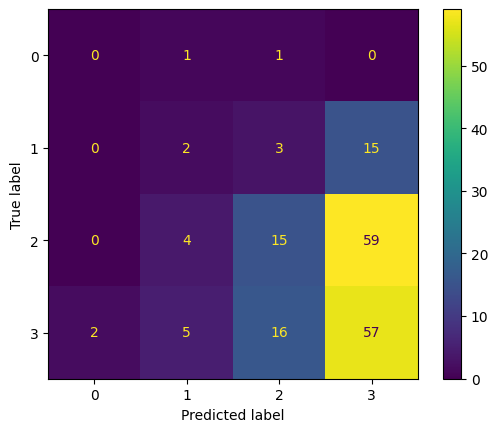

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

display = ConfusionMatrixDisplay.from_predictions(y_test, test_preds)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.17      0.10      0.12        20
           2       0.43      0.19      0.27        78
           3       0.44      0.71      0.54        80

    accuracy                           0.41       180
   macro avg       0.26      0.25      0.23       180
weighted avg       0.40      0.41      0.37       180

